# Semalytics walkthrough

Welcome to the Semalytics demo!


<a id='intro'></a>
## Introduction

This is an extended computational narrative focusing on the platform **Semalytics**, a semantic-based tool for analyzing hierarchical data in translational cancer research. This demo is bundled with the paper:

> _**Semalytics: a semantic analytics platform for the exploration of distributed and heterogenous cancer data (in translational research)**_

Biological annotations are modeled in a new **Semantic Web** fashion and are connected to **Wikidata** for knowledge expansion. Please, note that Semalytics explores annotations that are highly scattered along hierarchical data.

In this notebook, we are going to use Semalytics for analyzing a test dataset in order to investigate gene alteration-drug interactions. In particular, we focus on the response to the **Cetuximab**, an epidermal growth factor inhibitor used for the treatment of several cancer types, such as the colorectal cancer. Each cancer is a complex and variable system with unique characteristics at the molecular level, which may determine drugs performance. In this demo, we match drug responses data with annotations related to a set of 4 genes:

* BRAF
* EGFR
* HER2 
* KRAS

which are known to be relevant to Cetuximab response in colorectal cancer.

* In [Chapter 1](#insights), we show how the platform can be used for getting basic data insights about genomic landscapes and drug responses. In particular, we use Semalytics to identify an investigation set (i.e., data trees with both genomic and pharmacological annotations).

* In [Chapter 2](#inside), we explore data into the investigation set. First, we get the list of variants for the genes in the panel. Then, we explore the co-occurence of genomic variants and responses to Cetuximab.

* Finally, in [Chapter 3](#wikidata), we use Semalytics for analyzing local data harnessing the extended information of Wikidata, thus gaining new analytical options on our local database. For example, we use federated queries to explore of data about drugs different from Cetuximab, which we do not store and maintain locally.  

See the aforementioned article for further details.


## Table of contents

* [Introduction](#intro)
* [General settings](#settings)
* [Chapter 1 - Basic insights](#insights)
    - [Annotated nodes](#annotated)
    - [Genomic annotations](#genes)
    - [Response annotations](#mice) 
    - [Investigation set: genomic and responses annotations](#miceanddrug)
* [Chapter 2 - Inside the investigation set](#inside)
    - [Variants of non-responders](#variantsnonresp)
    - [Getting basic data for co-occurence analysis](#matchinggetdata)
    - [Matching annotations in the investigation set](#mset)
    - [Matching `feature_amplification` only](#mamplsubset)
    - [Matching `sequence_alteration` only](#mseqsubset)
* [Chapter 3 - Querying data with knowledge and Wikidata](#wikidata)
    - [Drugs targeting gene products](#drugsrole)
    - [Drug information: dabrafenib](#dabrafenib)
    - [Querying variants](#queryinnvar)
    - [Positive therapeutic predictors](#pos)
    - [Negative therapeutic predictors](#neg)
    - [Drugs predictions for a specific case](#case)

<a id='settings'></a>
## General settings

General imports and vars

In [1]:
import utils
import pandas as pd
from IPython.display import SVG, display

# SPARQL endpoints

# Semalytics (i.e., local data)
# 14,281,125 explicit triples
#  2,391,980 inferred triples
SEMALYTICS_ENDPOINT = 'http://semalytics:7200/repositories/annotationDB'

# Remote knowledge base
WIKIDATA_ENDPOINT = 'https://query.wikidata.org/sparql'

# genes panel
PANEL = {'BRAF','EGFR','ERBB2','KRAS'}

# investigated variants
VARIANTS = ':sequence_alteration :feature_amplification'

# enable inline plotting
%matplotlib inline

# do not truncate data in tables
pd.set_option('display.max_colwidth', -1)

<a id='insights'></a>
## Chapter 1 - Basic insights

We query Semalytics data for getting basic insights. Semalytics returns immediately analytics on scattered annotations.

<a id='annotated'></a>
### Annotated nodes

We use the following query to retrieve **annotated nodes** (samples for genes or mice for drug reponses).

In [2]:
# the query
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX onto: <http://www.ontotext.com/>
select (count(distinct ?node) as ?nodes)
from onto:disable-sameAs
where {
    ?case a :Case ;
          :hasDescendant ?node .
    ?node a :Bioentity ;
          :has_annotation ?ann .
}
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go!
result = result_table['nodes.value'][0] 
print(f'there are {result} annotated nodes in trees')

there are 3917 annotated nodes in trees


<a id='genes'></a>
### Genomic annotations

Let $\mathcal{G}$ be the set of data trees with annotations about `:sequence_alteration` or `:feature_amplification` for **genes in the panel**. We build $\mathcal{G}$ with the following query:

In [3]:
# Cases with annotations in the genes panel
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX onto: <http://www.ontotext.com/>
select (count(distinct ?case) as ?cases) 
from onto:disable-sameAs
where { 
    ?case a :Case ;
          :hasDescendant ?node .
    ?node :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?gene :has_variant ?ref.
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?ref a ?annotation_Type .
    VALUES ?annotation_Type { """+VARIANTS+"""  }
}
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go!
result = result_table['cases.value'][0] 
print(f'there are {result} cases annotated with 1+ variant(s) in the panel (KRAS, EGFR, BRAF, HER2)')

there are 354 cases annotated with 1+ variant(s) in the panel (KRAS, EGFR, BRAF, HER2)


<a id='mice'></a>
### Response annotations

Let $\mathcal{D}$ be the set of data trees with annotated mice about **pharmacological responses**. We build $\mathcal{D}$ with the following query:

In [4]:
# Cases with pharmacological annotations
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX onto: <http://www.ontotext.com/>
select ?drugName (count(distinct ?case) as ?cases)
from onto:disable-sameAs
where {
    ?case a :Case ;
          :hasDescendant ?mouse .
    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref a :drug_response .
    ?drug :has_drug_response ?ref;
          :name ?drugName .
}
GROUP BY ?drugName
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go!
drug,cases = result_table['drugName.value'][0],result_table['cases.value'][0]
print(f'there are {cases} cases annotated with 1+ pharmacological response(s) for the {drug}')

there are 238 cases annotated with 1+ pharmacological response(s) for the CETUXIMAB


<a id='miceanddrug'></a>
### Investigation set: genomic and responses annotations

Let $\mathcal{S} = (\mathcal{G} \cap \mathcal{D})$ be the investigation scope (i.e., data trees with both genomic and pharmacological annotations). We get it through this query:

In [5]:
# Cases with pharmacological and genomic annotations
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX onto: <http://www.ontotext.com/>
select (count(distinct ?case) as ?cases)
from onto:disable-sameAs
where {
    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .
    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref a :drug_response .
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?ref2 .
    ?gene :has_variant ?ref2.
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?ref2 a ?annotation_Type.
    VALUES ?annotation_Type { """+VARIANTS+""" }
}
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go!
investigation_scope = result_table['cases.value'][0]
print(f'there are {investigation_scope} cases annotated with 1+ pharmacological response(s) AND 1+ variant(s)')

there are 113 cases annotated with 1+ pharmacological response(s) AND 1+ variant(s)


<a id='inside'></a>
## Chapter 2 - Inside the investigation set

In this section we analyze annotation types for cases in the investigation set. Moreover, we exploit Semalytics for matching variants against responses to Cetuximab.

<a id='variantsnonresp'></a>
### Variants of non responders

With the following query, we get the **variants list** of non-responder cases. The column `alt_p.value` represents the type of `point_mutation`.

In [6]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX sesame: <http://www.openrdf.org/schema/sesame#>
PREFIX onto: <http://www.ontotext.com/>
select distinct ?case ?geneSymbol ?type ?alt_p
from onto:disable-sameAs
where {
    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .
    
    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref a :DRCl_PD .
    
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?ref2 .
    ?gene :has_variant ?ref2 ;
    :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?ref2 a ?annotation_Type.
    VALUES ?annotation_Type { :sequence_alteration :feature_amplification }
    ?ref2 sesame:directType ?type.
        OPTIONAL {?ref2 :alt_p ?alt_p }
}
ORDER BY ?case
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# filter URIs prefixes
utils.filter_prefixes(result_table)


# there you go!
result_table[['case.value', 'geneSymbol.value', 'type.value', 'alt_p.value']].fillna("")


,case.value,geneSymbol.value,type.value,alt_p.value
0,CRC0019,KRAS,point_mutation,G13D
1,CRC0021,KRAS,point_mutation,G12C
2,CRC0021,KRAS,point_mutation,G12V
3,CRC0024,KRAS,point_mutation,G13C
4,CRC0027,KRAS,point_mutation,G13D
5,CRC0028,KRAS,point_mutation,G13D
6,CRC0031,KRAS,point_mutation,G12D
7,CRC0053,KRAS,point_mutation,A146T
8,CRC0055,KRAS,point_mutation,G12V
9,CRC0058,KRAS,point_mutation,G12V


<a id='matchinggetdata'></a>
### Getting basic data for co-occurence analysis

Creating basic data for further investigations about gene variant - drug matching.

In [7]:
# data collections
cases_per_gene = dict()
cases_per_variant = dict()
cases_per_variant_per_gene = dict()
cases_per_response = dict()

We get **cases harboring 1+ variants for each gene in the panel**.

Please, note that we are counting distinct cases per gene. Therefore, cases harboring multiple variants in the same gene will be counted only once.

In [8]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX sesame: <http://www.openrdf.org/schema/sesame#>
PREFIX onto: <http://www.ontotext.com/>
select distinct ?case
from onto:disable-sameAs
where {{
    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .

    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .

    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?ref2 .
    ?gene :has_variant ?ref2 ;
          :symbol ?geneSymbol
    VALUES ?geneSymbol {{'{}'}}
    ?ref2 a ?annotation_Type.
    VALUES ?annotation_Type {{ :sequence_alteration :feature_amplification }}
    ?ref2 sesame:directType ?type. 
}}"""

for gene in PANEL:
    print (f'Querying {gene}')
    result_table = utils.query(SEMALYTICS_ENDPOINT, my_query.format(gene))
    cases_per_gene[gene] = set(result_table['case.value'])

print ('Cases outline:')
for key in cases_per_gene:
    print(f'{key}: {len(cases_per_gene[key])}')
    

Querying ERBB2
Querying KRAS
Querying EGFR
Querying BRAF
Cases outline:
ERBB2: 11
KRAS: 70
EGFR: 29
BRAF: 13


Then, we get cases **harboring 1+ `:sequence_alteration` or `:feature_amplification`**

Again, please, note that we are counting distinct cases per gene. Therefore, cases harboring multiple variants in the same gene will be counted only once.

In [9]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX sesame: <http://www.openrdf.org/schema/sesame#>
PREFIX onto: <http://www.ontotext.com/>
select distinct ?case 
from onto:disable-sameAs
where {{
    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .

    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .

    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?ref2 .
    ?gene :has_variant ?ref2 ;
          :symbol ?geneSymbol
    VALUES ?geneSymbol {{'KRAS' 'EGFR' 'BRAF' 'ERBB2'}}
    ?ref2 a ?annotation_Type.
    VALUES ?annotation_Type {{ :{} }}
    ?ref2 sesame:directType ?type. 
}}"""

for variant in ['sequence_alteration', 'feature_amplification']:
    print (f'Querying {variant}')
    result_table = utils.query(SEMALYTICS_ENDPOINT, my_query.format(variant))
    cases_per_variant[variant] =  set(result_table['case.value'])
       

print ('Cases outline:')
for variant in cases_per_variant:
    print(f'\t{variant} {len(cases_per_variant[variant])}')
    

Querying sequence_alteration
Querying feature_amplification
Cases outline:
	sequence_alteration 88
	feature_amplification 33


Besides, we get cases **harboring 1+ `:sequence_alteration` or `:feature_amplification` for each gene in the panel**.


In [10]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX sesame: <http://www.openrdf.org/schema/sesame#>
PREFIX onto: <http://www.ontotext.com/>
select distinct ?case 
from onto:disable-sameAs
where {{
    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .

    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .

    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?ref2 .
    ?gene :has_variant ?ref2 ;
          :symbol ?geneSymbol
    VALUES ?geneSymbol {{'{}'}}
    ?ref2 a ?annotation_Type.
    VALUES ?annotation_Type {{ :{} }}
    ?ref2 sesame:directType ?type. 
}}"""

for variant in ['sequence_alteration', 'feature_amplification']:
    print (f'Querying {variant}')
    cases_per_variant_per_gene[variant] = dict()
    for gene in PANEL:
        result_table = utils.query(SEMALYTICS_ENDPOINT, my_query.format(gene, variant))
        try:
            cases_per_variant_per_gene[variant][gene] =  set(result_table['case.value'])
        except KeyError:
            print (f'no data for {variant} - {gene}')

print ('Cases outline:')
for variant in cases_per_variant_per_gene:
        print(f'{variant}')
        for gene in cases_per_variant_per_gene[variant]:
            print(f'\t{gene} {len(cases_per_variant_per_gene[variant][gene])}')
    

Querying sequence_alteration
Querying feature_amplification
no data for feature_amplification - KRAS
no data for feature_amplification - BRAF
Cases outline:
sequence_alteration
	ERBB2 5
	KRAS 70
	EGFR 4
	BRAF 13
feature_amplification
	ERBB2 7
	EGFR 26


Variants summary:


|    Gene  | All variant types | :feature_amplification  | :sequence_alteration |
|-------------|-----|------------|-----|
| Annotated   | 113 | 33         | 88  |
| BRAF        | 13  | 0          | 13  |
| EGFR        | 29  | 26         | 4   |
| ERBB2       | 11  | 7          | 5   |
| KRAS        | 70  | 0          | 70  |

Finally, we get **cases per response type**.

In [11]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX sesame: <http://www.openrdf.org/schema/sesame#>
PREFIX onto: <http://www.ontotext.com/>
select distinct ?case 
from onto:disable-sameAs
where {{
    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .

    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref sesame:directType :{} .

    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?ref2 .
    ?gene :has_variant ?ref2 ;
          :symbol ?geneSymbol
    VALUES ?geneSymbol {{'KRAS' 'EGFR' 'BRAF' 'ERBB2'}}
    ?ref2 a ?annotation_Type.
    VALUES ?annotation_Type {{ :sequence_alteration :feature_amplification }}
    ?ref2 sesame:directType ?type. 
}}"""

for response in ['DRCl_OR', 'DRCl_SD', 'DRCl_PD']:
    print (f'Querying {response}')
    result_table = utils.query(SEMALYTICS_ENDPOINT, my_query.format(response))
    cases_per_response[response] = set(result_table['case.value'])

print ('Cases outline:')
for key in cases_per_response:
    print(f'{key}: {len(cases_per_response[key])}')

Querying DRCl_OR
Querying DRCl_SD
Querying DRCl_PD
Cases outline:
DRCl_OR: 7
DRCl_SD: 26
DRCl_PD: 80


Since we are also interested in analyzing **variants co-occurrences**, we enumerate all possible combinations (i.e., the power set). We will use these data in the next sections.

In [12]:
# create variants co-occurrences list (i.e., the power set of {'BRAF','EGFR','ERBB2','KRAS'})
variants_occurrences = list(utils.powerset(PANEL))
variants_occurrences.sort(key=len)

# just combinatorics
variants_occurrences

[(),
 ('BRAF',),
 ('ERBB2',),
 ('KRAS',),
 ('EGFR',),
 ('KRAS', 'EGFR'),
 ('KRAS', 'BRAF'),
 ('ERBB2', 'BRAF'),
 ('ERBB2', 'KRAS'),
 ('ERBB2', 'EGFR'),
 ('EGFR', 'BRAF'),
 ('ERBB2', 'EGFR', 'BRAF'),
 ('ERBB2', 'KRAS', 'EGFR'),
 ('ERBB2', 'KRAS', 'BRAF'),
 ('KRAS', 'EGFR', 'BRAF'),
 ('ERBB2', 'KRAS', 'EGFR', 'BRAF')]

<a id='mset'></a>
### Matching annotations in the investigation set

We analyze all annotated cases and we match drug information with gene variants data.

In [13]:
# the investigation set
tot = cases_per_gene['BRAF'] | cases_per_gene['EGFR'] | cases_per_gene['ERBB2'] | cases_per_gene['KRAS']

print(len(tot))

113


In [14]:
# create a new Semalytics analysis object
a = utils.Analysis(tot, cases_per_gene, cases_per_response, variants_occurrences)

# gene variants
a.variants

,gene,case
0,Annotated,113
1,BRAF,13
2,EGFR,29
3,ERBB2,11
4,KRAS,70


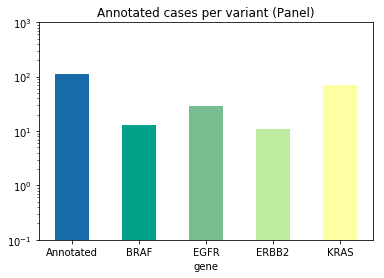

In [15]:
# plot variants distribution
a.plot_variants()

In [16]:
# responses
a.responses

,response_type,case
0,response,7
1,neutral,26
2,progression,80


Text(0, 0.5, '')

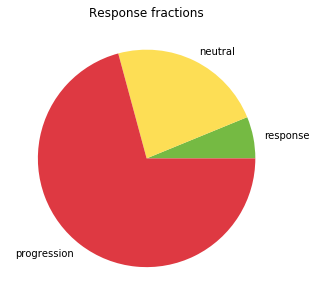

In [17]:
# plot responses
a.plot_responses()

In [18]:
# variants vs responses
a.matching.fillna("")

,genes,DRCl_PD,DRCl_SD,DRCl_OR,tot,progression,neutral,response
0,"(BRAF,)",13,0,0,13,1,0,0
1,"(ERBB2,)",8,1,2,11,0.727273,0.0909091,0.181818
2,"(KRAS,)",56,14,0,70,0.8,0.2,0
3,"(EGFR,)",10,14,5,29,0.344828,0.482759,0.172414
4,"(KRAS, EGFR)",3,3,0,6,0.5,0.5,0
5,"(KRAS, BRAF)",2,0,0,2,1,0,0
6,"(ERBB2, BRAF)",0,0,0,0,,,
7,"(ERBB2, KRAS)",1,0,0,1,1,0,0
8,"(ERBB2, EGFR)",0,0,0,0,,,
9,"(EGFR, BRAF)",1,0,0,1,1,0,0


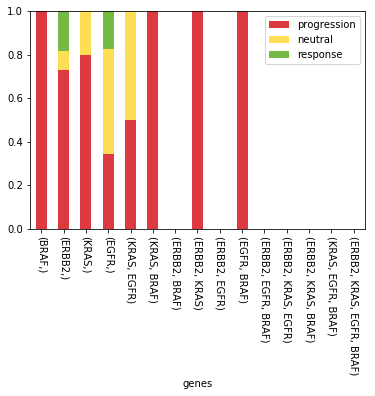

In [19]:
# plot matching
a.plot_matching()

<a id='mamplsubset'></a>
### Matching `feature_amplification` only

We analyze cases with only 1+ `feature_amplification` (and with no `sequence_alteration`)

In [20]:
# create the subset
tot = cases_per_variant['feature_amplification'] - cases_per_variant['sequence_alteration']
print(len(tot))

25


In [21]:
# create a new Semalytics analysis object
a = utils.Analysis(tot, cases_per_gene, cases_per_response, variants_occurrences)

# gene variants
a.variants

,gene,case
0,Annotated,25
1,BRAF,0
2,EGFR,19
3,ERBB2,6
4,KRAS,0


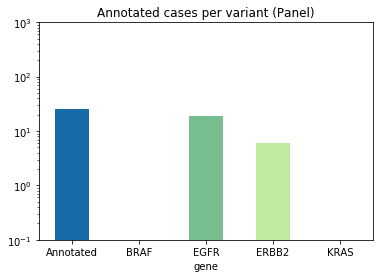

In [22]:
# plot variants distribution
a.plot_variants()

In [23]:
# responses
a.responses

,response_type,case
0,response,7
1,neutral,9
2,progression,9


Text(0, 0.5, '')

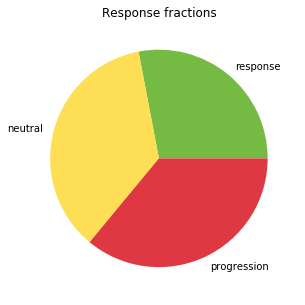

In [24]:
# plot responses
a.plot_responses()

In [25]:
# variants vs responses
a.matching.fillna("")

,genes,DRCl_PD,DRCl_SD,DRCl_OR,tot,progression,neutral,response
0,"(BRAF,)",0,0,0,0,,,
1,"(ERBB2,)",4,0,2,6,0.666667,0,0.333333
2,"(KRAS,)",0,0,0,0,,,
3,"(EGFR,)",5,9,5,19,0.263158,0.473684,0.263158
4,"(KRAS, EGFR)",0,0,0,0,,,
5,"(KRAS, BRAF)",0,0,0,0,,,
6,"(ERBB2, BRAF)",0,0,0,0,,,
7,"(ERBB2, KRAS)",0,0,0,0,,,
8,"(ERBB2, EGFR)",0,0,0,0,,,
9,"(EGFR, BRAF)",0,0,0,0,,,


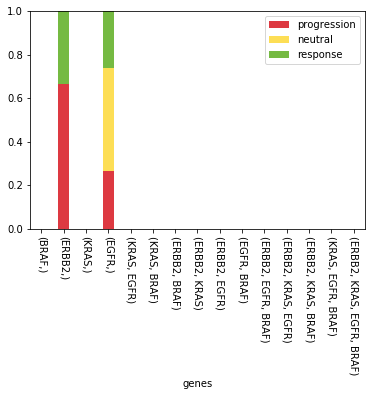

In [26]:
# plot matching
a.plot_matching()

<a id='mseqsubset'></a>
### Matching `sequence_alteration` only

We analyze cases with only 1+ `sequence_alteration` (and with no `feature_amplification`)

In [27]:
# create the subset
tot = cases_per_variant['sequence_alteration'] - cases_per_variant['feature_amplification']
print (len(tot))

80


In [28]:
# create a new Semalytics analysis object
a = utils.Analysis(tot, cases_per_gene, cases_per_response, variants_occurrences)

# gene variants
a.variants

,gene,case
0,Annotated,80
1,BRAF,12
2,EGFR,3
3,ERBB2,4
4,KRAS,65


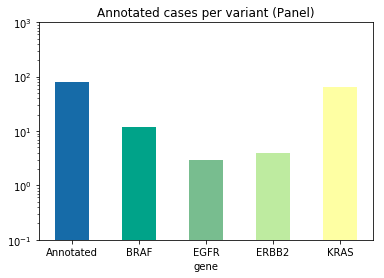

In [29]:
# plot variants distribution
a.plot_variants()

In [30]:
# responses
a.responses

,response_type,case
0,response,0
1,neutral,14
2,progression,66


Text(0, 0.5, '')

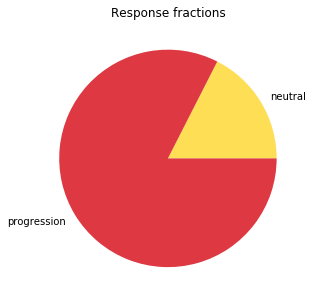

In [31]:
# plot responses
a.plot_responses()

In [32]:
# variants vs responses
a.matching.fillna("")

,genes,DRCl_PD,DRCl_SD,DRCl_OR,tot,progression,neutral,response
0,"(BRAF,)",12,0,0,12,1,0,0
1,"(ERBB2,)",3,1,0,4,0.75,0.25,0
2,"(KRAS,)",54,11,0,65,0.830769,0.169231,0
3,"(EGFR,)",1,2,0,3,0.333333,0.666667,0
4,"(KRAS, EGFR)",1,0,0,1,1,0,0
5,"(KRAS, BRAF)",2,0,0,2,1,0,0
6,"(ERBB2, BRAF)",0,0,0,0,,,
7,"(ERBB2, KRAS)",1,0,0,1,1,0,0
8,"(ERBB2, EGFR)",0,0,0,0,,,
9,"(EGFR, BRAF)",0,0,0,0,,,


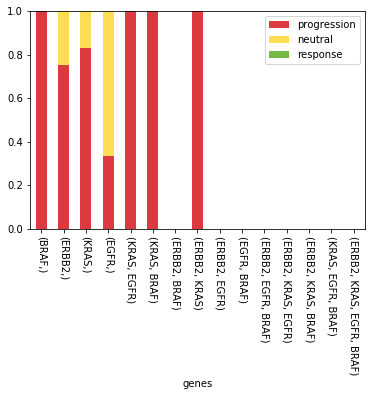

In [33]:
# plot matching
a.plot_matching()

<a id='wikidata'></a>
## Chapter 3 - Querying data with knowlege and Wikidata

In this section, we are going to query data with extended knowledge. The platform connects Wikidata by leveraging `owl:sameAs` predicates.

The SPARQL endpoint of Semalytics is federated with the Wikidata one (https://query.wikidata.org/sparql).

See also this [Web page](https://www.wikidata.org/wiki/User:ProteinBoxBot/SPARQL_Examples#Query_Wikidata_with_SPARQL) for other Wikidata examples related to life sciences. Those queries can be also used for querying local data in Semalytics.

<a id='drugsrole'></a>
### Drugs targeting gene products

We get chemical compounds (`Q11173`) which physically interacts (`P129`), with a specific role (`P2868`), with products encoded by genes in the investigation panel.

In [34]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

select ?geneSymbol ?drugLabel ?roleLabel ?gene_productLabel
where {

    # Wikidata endpoint 
    SERVICE <https://query.wikidata.org/sparql> {

        ?chem p:P129 [
            ps:P129 ?gene_product ;
            pq:P2868 ?role ] .
        ?chem wdt:P31 wd:Q11173 .
        ?gene_product wdt:P702 ?gene .

        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" . 
            ?chem rdfs:label ?drugLabel .
            ?gene_product rdfs:label ?gene_productLabel .
            ?role rdfs:label ?roleLabel .
        }
    }
    
    #local data
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
}
order by ?geneSymbol
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go!
result_table[['geneSymbol.value', 'drugLabel.value', 'roleLabel.value', 'gene_productLabel.value']]

,geneSymbol.value,drugLabel.value,roleLabel.value,gene_productLabel.value
0,BRAF,dabrafenib,enzyme inhibitor,"B-Raf proto-oncogene, serine/threonine kinase"
1,BRAF,regorafenib,enzyme inhibitor,"B-Raf proto-oncogene, serine/threonine kinase"
2,BRAF,sorafenib,enzyme inhibitor,"B-Raf proto-oncogene, serine/threonine kinase"
3,BRAF,vemurafenib,enzyme inhibitor,"B-Raf proto-oncogene, serine/threonine kinase"
4,EGFR,icotinib,enzyme inhibitor,Epidermal growth factor receptor
5,EGFR,dacomitinib,enzyme inhibitor,Epidermal growth factor receptor
6,EGFR,osimertinib,enzyme inhibitor,Epidermal growth factor receptor
7,EGFR,gefitinib,enzyme inhibitor,Epidermal growth factor receptor
8,EGFR,erlotinib,enzyme inhibitor,Epidermal growth factor receptor
9,EGFR,lapatinib,enzyme inhibitor,Epidermal growth factor receptor


<a id='dabrafenib'></a>
### Drug information: dabrafenib

Now we get from Wikidata the  **chemical formula** (P274) of one of those drug: the **dabrafenib**...

In [35]:
my_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT *
WHERE 
{
  wd:Q3011604 wdt:P274 ?chem .
}
"""

# get data
result_table = utils.query(WIKIDATA_ENDPOINT, my_query)

result_table

,chem.type,chem.value
0,literal,C₂₃H₂₀F₃N₅O₂S₂


...as well as its **chemical structure** (`P117`).

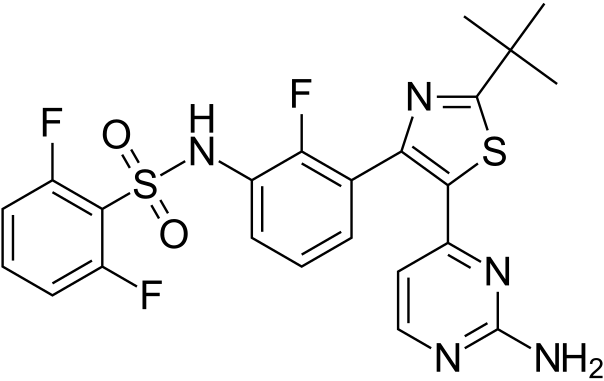

live rendering from Wikidata of http://commons.wikimedia.org/wiki/Special:FilePath/Dabrafenib.svg


In [36]:
my_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT *
WHERE 
{
  wd:Q3011604 wdt:P117 ?struct .
}
"""

# get data
result_table = utils.query(WIKIDATA_ENDPOINT, my_query)

display(SVG(url=result_table['struct.value'][0]))

print (f'live rendering from Wikidata of {result_table["struct.value"][0]}')


Finally, we get **medical conditions treated** (P2175), relative data source (1) and information retrieval date.

_(1) "dataset containing drug indications extracted from the FDA Adverse Event Reporting System"_

In [37]:
my_query = """
SELECT ?medical_conditionLabel ?referenceLabel ?date
WHERE 
{
  wd:Q3011604 p:P2175 [
    ps:P2175 ?medical_condition ;
   prov:wasDerivedFrom ?source 
  ].
  ?source pr:P248 ?reference ;
          pr:P813 ?date
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

# get data
result_table = utils.query(WIKIDATA_ENDPOINT, my_query)

# there you go
result_table[['medical_conditionLabel.value', 'referenceLabel.value', 'date.value']]

,medical_conditionLabel.value,referenceLabel.value,date.value
0,non-small-cell lung carcinoma,Drug Indications Extracted from FAERS,2018-10-02T00:00:00Z
1,skin cancer,Drug Indications Extracted from FAERS,2018-10-02T00:00:00Z
2,metastatic melanoma,Drug Indications Extracted from FAERS,2018-10-02T00:00:00Z
3,melanoma,Drug Indications Extracted from FAERS,2018-10-02T00:00:00Z


<a id='queryinnvar'></a>
### Querying variants

We can also query only cases with variants mapped to Wikidata. Those are entry points for knowledge enrichment. The column `alt_p.value` represents the type of `point_mutation`.

In [38]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
select distinct ?case ?variant ?geneSymbol ?alt_p ?annotation_Type

where {

    SERVICE <https://query.wikidata.org/sparql> {
        ?variant wdt:P3329 ?id .
    }


    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .
    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref a :drug_response .
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?variant .
    ?gene :has_variant ?variant.
    OPTIONAL {?variant :alt_p ?alt_p }
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?variant a ?annotation_Type.
    VALUES ?annotation_Type { :sequence_alteration :feature_amplification }
}
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# filter URIs prefixes
utils.filter_prefixes(result_table)

# there you go
result_table[['case.value', 'variant.value', 'geneSymbol.value', 'alt_p.value', 'annotation_Type.value']].fillna("")

,case.value,variant.value,geneSymbol.value,alt_p.value,annotation_Type.value
0,CRC0354,Q29938363,KRAS,Q61H,sequence_alteration
1,CRC0139,Q29938363,KRAS,Q61H,sequence_alteration
2,CRC0438,Q29938368,KRAS,Q61K,sequence_alteration
3,CRC0024,Q32948338,KRAS,G13C,sequence_alteration
4,CRC0315,Q28371015,KRAS,G13D,sequence_alteration
5,CRC0127,Q28371015,KRAS,G13D,sequence_alteration
6,CRC0071,Q28371015,KRAS,G13D,sequence_alteration
7,CRC0237,Q28371015,KRAS,G13D,sequence_alteration
8,CRC0018,Q28371015,KRAS,G13D,sequence_alteration
9,CRC0019,Q28371015,KRAS,G13D,sequence_alteration


<a id='pos'></a>
## Positive therapeutic predictors

We can use the **variants occurrences** annotated in the local database for querying **associated positive response predictions** to drugs. Moreover, we retrieve also the scientific article from where the evidence comes and the relative medical condition treated.

In [39]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pr: <http://www.wikidata.org/prop/reference/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select distinct ?geneSymbol ?variantLabel ?treatmentLabel ?diseaseLabel ?referenceLabel

where {

    SERVICE <https://query.wikidata.org/sparql> {
        ?variant wdt:P3329 ?id .
        ?variant p:P3354 [ ps:P3354 ?treatment ; 
                           pq:P2175 ?disease ;
                           prov:wasDerivedFrom ?source ].
        ?source pr:P248 ?reference    

        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" . 
            ?variant rdfs:label ?variantLabel .
            ?treatment rdfs:label ?treatmentLabel .
            ?disease rdfs:label ?diseaseLabel .
            ?reference rdfs:label ?referenceLabel
        }
    }


    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .
    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref a :drug_response .
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?variant .
    ?gene :has_variant ?variant.
    OPTIONAL {?variant :alt_p ?alt_p }
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?variant a ?annotation_Type.
    VALUES ?annotation_Type { :sequence_alteration :feature_amplification }
}
order by ?geneSymbol
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go
result_table[['geneSymbol.value', 'variantLabel.value', 'treatmentLabel.value', 'diseaseLabel.value', 'referenceLabel.value']]

,geneSymbol.value,variantLabel.value,treatmentLabel.value,diseaseLabel.value,referenceLabel.value
0,BRAF,BRAF G466V,vemurafenib,cancer,"Targeted Therapy for Advanced Solid Tumors on the Basis of Molecular Profiles: Results From MyPathway, an Open-Label, Phase IIa Multiple Basket Study."
1,BRAF,BRAF K601E,vemurafenib,skin melanoma,BRAF(L597) mutations in melanoma are associated with sensitivity to MEK inhibitors
2,BRAF,BRAF K601E,trametinib,skin melanoma,BRAF(L597) mutations in melanoma are associated with sensitivity to MEK inhibitors
3,BRAF,BRAF V600E,cobimetinib fumarate,cancer,Mechanism of MEK inhibition determines efficacy in mutant KRAS- versus BRAF-driven cancers
4,BRAF,BRAF V600E,vemurafenib,ovarian cancer,"Targeted Therapy for Advanced Solid Tumors on the Basis of Molecular Profiles: Results From MyPathway, an Open-Label, Phase IIa Multiple Basket Study."
5,BRAF,BRAF V600E,Dabrafenib / Trametinib combination therapy,melanoma,Combined BRAF and MEK inhibition in melanoma with BRAF V600 mutations
6,BRAF,BRAF V600E,vemurafenib,melanoma,"Safety and efficacy of vemurafenib in BRAF(V600E) and BRAF(V600K) mutation-positive melanoma (BRIM-3): extended follow-up of a phase 3, randomised, open-label study"
7,BRAF,BRAF V600E,Dabrafenib / Trametinib combination therapy,melanoma,"Dabrafenib and trametinib, alone and in combination for BRAF-mutant metastatic melanoma."
8,BRAF,BRAF V600E,vemurafenib / cobimetinib fumarate combination therapy,melanoma,Combined vemurafenib and cobimetinib in BRAF-mutated melanoma.
9,BRAF,BRAF V600E,pictilisib,melanoma,"First-in-human phase I study of pictilisib (GDC-0941), a potent pan-class I phosphatidylinositol-3-kinase (PI3K) inhibitor, in patients with advanced solid tumors."


<a id='neg'></a>
## Negative therapeutic predictors

We can use the **variants occurrences** annotated in the local database for querying associated **negative response predictions** to drugs. Moreover, we retrieve also the scientific article from where the evidence comes and the relative medical condition treated.

In [40]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pr: <http://www.wikidata.org/prop/reference/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select distinct ?geneSymbol ?variantLabel ?treatmentLabel ?diseaseLabel ?referenceLabel

where {

    SERVICE <https://query.wikidata.org/sparql> {
        ?variant wdt:P3329 ?id .
        ?variant p:P3355 [ ps:P3355 ?treatment ; 
                           pq:P2175 ?disease ;
                           prov:wasDerivedFrom ?source ].
        ?source pr:P248 ?reference    

        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" . 
            ?variant rdfs:label ?variantLabel .
            ?treatment rdfs:label ?treatmentLabel .
            ?disease rdfs:label ?diseaseLabel .
            ?reference rdfs:label ?referenceLabel
        }
    }


    ?case a :Case ;
          :hasDescendant ?mouse ;
          :hasDescendant ?node .
    ?mouse a :Biomouse ;
           :has_annotation ?ann .
    ?ann :has_reference ?ref .
    ?ref a :drug_response .
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?variant .
    ?gene :has_variant ?variant.
    OPTIONAL {?variant :alt_p ?alt_p }
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?variant a ?annotation_Type.
    VALUES ?annotation_Type { :sequence_alteration :feature_amplification }
}
order by ?geneSymbol
"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go
result_table[['geneSymbol.value', 'variantLabel.value', 'treatmentLabel.value', 'diseaseLabel.value', 'referenceLabel.value']]

,geneSymbol.value,variantLabel.value,treatmentLabel.value,diseaseLabel.value,referenceLabel.value
0,BRAF,BRAF V600E,vemurafenib,melanoma,Loss of NF1 in cutaneous melanoma is associated with RAS activation and MEK dependence.
1,BRAF,BRAF V600E,pd-0325901,melanoma,Loss of NF1 in cutaneous melanoma is associated with RAS activation and MEK dependence.
2,BRAF,BRAF V600E,trametinib,melanoma,Loss of NF1 in cutaneous melanoma is associated with RAS activation and MEK dependence.
3,BRAF,BRAF V600E,Panitumumab,colorectal cancer,Meta-analysis of BRAF mutation as a predictive biomarker of benefit from anti-EGFR monoclonal antibody therapy for RAS wild-type metastatic colorectal cancer
4,BRAF,BRAF V600E,Cetuximab,colorectal cancer,Meta-analysis of BRAF mutation as a predictive biomarker of benefit from anti-EGFR monoclonal antibody therapy for RAS wild-type metastatic colorectal cancer
5,BRAF,BRAF V600E,irinotecan,colorectal cancer,Prognostic and predictive value of common mutations for treatment response and survival in patients with metastatic colorectal cancer.
6,BRAF,BRAF V600E,Oxaliplatin,colorectal cancer,Prognostic and predictive value of common mutations for treatment response and survival in patients with metastatic colorectal cancer.
7,BRAF,BRAF V600E,dabrafenib,non-small-cell lung carcinoma,Molecular characterization of acquired resistance to the BRAF inhibitor dabrafenib in a patient with BRAF-mutant non-small-cell lung cancer.
8,EGFR,EGFR G465R,Panitumumab,colorectal cancer,The First-in-class Anti-EGFR Antibody Mixture Sym004 Overcomes Cetuximab Resistance Mediated by EGFR Extracellular Domain Mutations in Colorectal Cancer.
9,EGFR,EGFR G465R,Cetuximab,colorectal cancer,The First-in-class Anti-EGFR Antibody Mixture Sym004 Overcomes Cetuximab Resistance Mediated by EGFR Extracellular Domain Mutations in Colorectal Cancer.


<a id='case'></a>
### Drugs predictions for a specific case

We can use the connection to Wikidata for querying evidences of drug responses predictions (i.e., positive or negative) associated with variants harbored by a specific case (i.e., _id=CRC0481_)

**Positive responses predictions**

In [41]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pr: <http://www.wikidata.org/prop/reference/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select distinct ?geneSymbol ?variantLabel ?treatmentLabel ?diseaseLabel ?referenceLabel
where {
    SERVICE <https://query.wikidata.org/sparql> {
        ?variant wdt:P3329 ?id .
        ?variant p:P3354 [ ps:P3354 ?treatment ; 
                           pq:P2175 ?disease ;
                           prov:wasDerivedFrom ?source ].
        ?source pr:P248 ?reference
        
        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" . 
            ?variant rdfs:label ?variantLabel .
            ?treatment rdfs:label ?treatmentLabel .
            ?disease rdfs:label ?diseaseLabel .
            ?reference rdfs:label ?referenceLabel .
        }
    }


    :CRC0481 :hasDescendant ?node .
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?variant .
    ?gene :has_variant ?variant.
    OPTIONAL {?variant :alt_p ?alt_p }
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?variant a ?annotation_Type.
    VALUES ?annotation_Type { :sequence_alteration :feature_amplification }
}

order by ?geneSymbol

"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go
result_table[['geneSymbol.value', 'variantLabel.value', 'treatmentLabel.value', 'diseaseLabel.value', 'referenceLabel.value']]

,geneSymbol.value,variantLabel.value,treatmentLabel.value,diseaseLabel.value,referenceLabel.value
0,EGFR,EGFR AMPLIFICATION,Cetuximab / platinum / fluorouracil combination therapy,head and neck squamous cell carcinoma,Evaluation of EGFR gene copy number as a predictive biomarker for the efficacy of cetuximab in combination with chemotherapy in the first-line treatment of recurrent and/or metastatic squamous cell carcinoma of the head and neck: EXTREME study.
1,EGFR,EGFR AMPLIFICATION,Cetuximab,colorectal cancer,Clinical usefulness of EGFR gene copy number as a predictive marker in colorectal cancer patients treated with cetuximab: a fluorescent in situ hybridization study.
2,EGFR,EGFR AMPLIFICATION,Panitumumab,colorectal cancer,EGFR gene copy number as a predictive biomarker for resistance to anti-EGFR monoclonal antibodies in metastatic colorectal cancer treatment: a meta-analysis.
3,EGFR,EGFR AMPLIFICATION,Cetuximab,colorectal cancer,EGFR gene copy number as a predictive biomarker for resistance to anti-EGFR monoclonal antibodies in metastatic colorectal cancer treatment: a meta-analysis.
4,EGFR,EGFR AMPLIFICATION,gefitinib,non-small-cell lung carcinoma,Epidermal Growth Factor Receptor Gene Amplification in Patients with Advanced-stage NSCLC.
5,EGFR,EGFR AMPLIFICATION,erlotinib,non-small-cell lung carcinoma,Epidermal Growth Factor Receptor Gene Amplification in Patients with Advanced-stage NSCLC.
6,KRAS,KRAS G13D,Cetuximab,colorectal cancer,Association of KRAS p.G13D mutation with outcome in patients with chemotherapy-refractory metastatic colorectal cancer treated with cetuximab.
7,KRAS,KRAS G13D,selumetinib / dactolisib combination therapy,colorectal cancer,Inhibition of MEK and PI3K/mTOR suppresses tumor growth but does not cause tumor regression in patient-derived xenografts of RAS-mutant colorectal carcinomas.


**Negative responses predictions**

In [42]:
my_query = """
PREFIX : <http://las.ircc.it/ontology/annotationplatform#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pr: <http://www.wikidata.org/prop/reference/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select distinct ?geneSymbol ?variantLabel ?treatmentLabel ?diseaseLabel ?referenceLabel
where {
    SERVICE <https://query.wikidata.org/sparql> {
        ?variant wdt:P3329 ?id .
        ?variant p:P3355 [ ps:P3355 ?treatment ; 
                           pq:P2175 ?disease ;
                           prov:wasDerivedFrom ?source ].
        ?source pr:P248 ?reference
        
        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" . 
            ?variant rdfs:label ?variantLabel .
            ?treatment rdfs:label ?treatmentLabel .
            ?disease rdfs:label ?diseaseLabel .
            ?reference rdfs:label ?referenceLabel .
        }
    }


    :CRC0481 :hasDescendant ?node .
    ?node :has_annotation ?ann2 .
    ?ann2 :has_reference ?variant .
    ?gene :has_variant ?variant.
    OPTIONAL {?variant :alt_p ?alt_p }
    ?gene :symbol ?geneSymbol
    VALUES ?geneSymbol {'KRAS' 'EGFR' 'BRAF' 'ERBB2'}
    ?variant a ?annotation_Type.
    VALUES ?annotation_Type { :sequence_alteration :feature_amplification }
}

order by ?geneSymbol

"""

# get data
result_table = utils.query(SEMALYTICS_ENDPOINT, my_query)

# there you go
result_table[['geneSymbol.value', 'variantLabel.value', 'treatmentLabel.value', 'diseaseLabel.value', 'referenceLabel.value']]

,geneSymbol.value,variantLabel.value,treatmentLabel.value,diseaseLabel.value,referenceLabel.value
0,EGFR,EGFR AMPLIFICATION,osimertinib,non-small-cell lung carcinoma,Amplification of EGFR Wild-Type Alleles in Non-Small Cell Lung Cancer Cells Confers Acquired Resistance to Mutation-Selective EGFR Tyrosine Kinase Inhibitors.
1,EGFR,EGFR AMPLIFICATION,rociletinib,non-small-cell lung carcinoma,Amplification of EGFR Wild-Type Alleles in Non-Small Cell Lung Cancer Cells Confers Acquired Resistance to Mutation-Selective EGFR Tyrosine Kinase Inhibitors.
2,KRAS,KRAS G13D,Panitumumab,colorectal cancer,PIK3CA mutations in colorectal cancer are associated with clinical resistance to EGFR-targeted monoclonal antibodies.
3,KRAS,KRAS G13D,Cetuximab,colorectal cancer,PIK3CA mutations in colorectal cancer are associated with clinical resistance to EGFR-targeted monoclonal antibodies.
4,KRAS,KRAS G13D,Cetuximab,colorectal cancer,Phase II study of single-agent cetuximab in KRAS G13D mutant metastatic colorectal cancer.
5,KRAS,KRAS G13D,Cetuximab,colorectal cancer,Cetuximab treatment for metastatic colorectal cancer with KRAS p.G13D mutations improves progression-free survival.
6,KRAS,KRAS G13D,Cetuximab,colorectal cancer,Meta-analysis comparing the efficacy of anti-EGFR monoclonal antibody therapy between KRAS G13D and other KRAS mutant metastatic colorectal cancer tumours.
